# Bike Safety Final Models

## Introduction

The goal of this project is to create a Predictive Model that is able to predict how severe a bike accident was:

For this, we have two target columns we plan to use in different ways:
- BikeInjury, which classifies how severe the injury of a biker was: from No Injury to Killed.
- AmbulanceR, which tells us whether an ambulance was called or not to the scene.

In the following sections, we'll tackle different ways of using these columns as our target column.

In this section, we'll set up the code required for all approaches.

In [120]:
# Visualization and data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing and metrics libraries
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, ConfusionMatrixDisplay

# Machine learning models libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [121]:
# Read out our database of bike accidents
BikeCrashData = pd.read_csv('../data/NCDOT_BikePedCrash.csv')

## Exploratory Data Analysis (EDA)

In [122]:
BikeCrashData.head()

,X,Y,OBJECTID,AmbulanceR,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,...,RdConfig,RdDefects,RdFeature,RdSurface,Region,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone
0,-78.883896,36.039490,1,Yes,11,11-15,.,No,With Traffic,B: Suspected Minor Injury,...,"Two-Way, Divided, Unprotected Median",NaN,No Special Feature,Smooth Asphalt,Piedmont,Urban,30 - 35 MPH,No Control Present,Clear,No
1,-78.782800,35.751118,2,Yes,20,20-24,.,No,Facing Traffic,C: Possible Injury,...,"Two-Way, Divided, Unprotected Median",NaN,Four-Way Intersection,Smooth Asphalt,Piedmont,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No
2,-80.697820,35.084732,3,Yes,37,30-39,.,No,Unknown,B: Suspected Minor Injury,...,"Two-Way, Not Divided",NaN,No Special Feature,Smooth Asphalt,Piedmont,Urban,20 - 25 MPH,No Control Present,Cloudy,No
3,-80.479320,35.684400,4,Yes,30,30-39,.,No,With Traffic,C: Possible Injury,...,"Two-Way, Not Divided",NaN,Four-Way Intersection,Smooth Asphalt,Piedmont,Urban,30 - 35 MPH,No Control Present,Cloudy,No
4,-78.904450,34.999428,5,Yes,45,40-49,.,No,With Traffic,B: Suspected Minor Injury,...,"Two-Way, Not Divided",NaN,No Special Feature,Coarse Asphalt,Coastal,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No


We explored our data by plotting various charts and graphs to better understand the correlation between features.

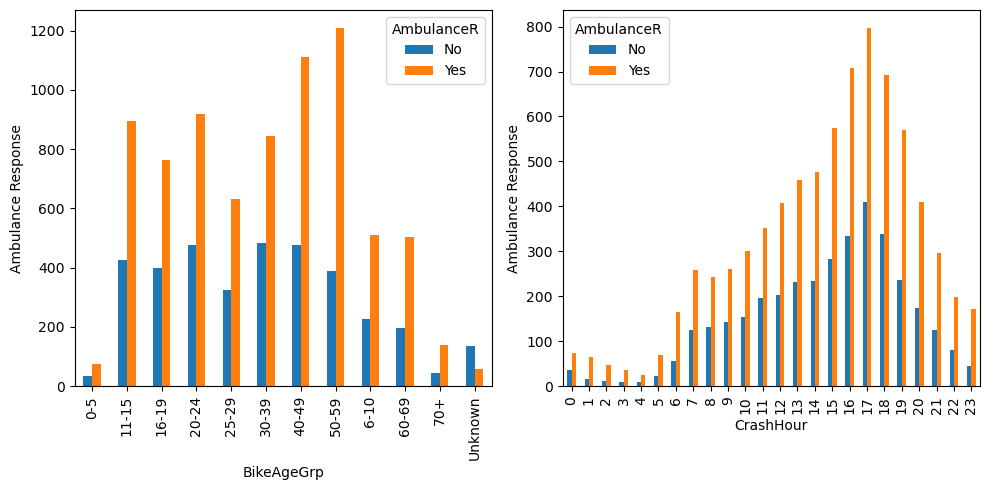

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

pd.crosstab(BikeCrashData['BikeAgeGrp'], BikeCrashData['AmbulanceR']).plot(kind='bar', ax=axes[0], stacked=False)
axes[0].set_ylabel('Ambulance Response')

pd.crosstab(BikeCrashData['CrashHour'], BikeCrashData['AmbulanceR']).plot(kind='bar', ax=axes[1], stacked=False)
axes[1].set_ylabel('Ambulance Response')

plt.tight_layout()
plt.show()

## Data Preprocessing

Below, we prepare our data for our models to be trained on. First, we select what we think are the most relevant features of our data in order to predict bike injuries and ambulance response rates. For example, we decided to throw out the feature `RdDefects` since this column consists of mostly `NaN` values. We also have decided to toss out all features containing only information on the drivers who were the cause of the accident on scene, since we believe this information serves little use to bikers themselves and city officials. 

Next, we simplify columns by combining their categories into fewer groups in order to simplify the data for our models to prevent overfitting. 

In [124]:
# Keeping only the relevant columns
BikeCrashData = BikeCrashData[['AmbulanceR','BikeAgeGrp','BikeDir', 'BikeInjury', 'BikePos',
                               'BikeRace', 'BikeSex', 'CrashDay', 'CrashHour', 'CrashMonth',
                                'NumLanes','RdConditio', 'RdConfig','RdFeature', 'RdSurface', 
                                'RuralUrban', 'SpeedLimit', 'Weather', 'Workzone']]


# Recombining speed limit into three categories
# 1. Low (0-25 mph)
# 2. Medium (26-45 mph)
# 3. High (46+ mph)
def speed_limit(x):
    if x in ['5 - 15 MPH', '20 - 25  MPH', 'Unknown']:
        return 0
    
    elif x in ['30 - 35  MPH', '40 - 45  MPH']:
        return 1
    
    else:
        return 2
    
BikeCrashData['SpeedLimit'] = BikeCrashData['SpeedLimit'].apply(speed_limit)

# Combine months into seasons
def month_season(x):
    if x in ['December','January', 'February']:
        return 0
    
    elif x in ['March','April', 'May']:
        return 1
    
    elif x in ['June','July', 'August']:
        return 2
    
    else:
        return 3

BikeCrashData['CrashMonth'] = BikeCrashData['CrashMonth'].apply(month_season)

# Combine hours into day parts
def day_part(hour):
    if hour < 6:
        return 0
    
    elif hour < 12:
        return 1
    
    elif hour < 18:
        return 2
    
    else:
        return 3
    
BikeCrashData['CrashHour'] = BikeCrashData['CrashHour'].apply(day_part)

# Combinging age groups in three categories
def age_group(x):
    if x in ['0-5', '6-10', '11-15', '16-19']:
        return 0
    
    elif x in ['20-24', '25-29', '30-39' ]:
        return 1
    
    else:
        return 2

BikeCrashData['BikeAgeGrp'] = BikeCrashData['BikeAgeGrp'].apply(age_group)

# Adding a binary column for the two main targets 
BikeCrashData['AmbulanceR'] = BikeCrashData['AmbulanceR'].map({'No':1, 'Yes':0}) # NOTE THE CHANGE in notation here

# Dropping unknown injuries
BikeCrashData.drop(BikeCrashData[BikeCrashData['BikeInjury'] == 'Unknown Injury'].index, inplace=True)

# Recombining injuries into two main classes (Light '1' and Severe '0')
injury_mapping = {'B: Suspected Minor Injury':0,
                  'C: Possible Injury':0, 
                  'O: No Injury':0,
                  'K: Killed':1,
                  'A: Suspected Serious Injury':1}

BikeCrashData['BikeInjury'] = BikeCrashData['BikeInjury'].map(injury_mapping)
# Again, NOTE keeping the minority class as 1 and the majority class as 0. 
# This is important for the model to work properly for imbalanced data.

# For the remaining (categorical) features, we assign numerical values with One-Hot encoding 
BikeCrashData = pd.get_dummies(BikeCrashData, drop_first=True)*1

In [125]:
# Save this k-fold to use for all cross validations and grid searches later on
n_splits = 5
kfold = StratifiedKFold(n_splits,
              shuffle = True,
              random_state = 582)

In [126]:
def model_metrics(model, X_train, y_train, kfold, pos_label = 1):
    """
    model_metrics function is used to evaluate the model performance using k-fold cross-validation.
    It calculates various metrics such as accuracy, precision, recall, f1-score, and roc_auc_score and returns the mean of these metrics.
    The function also visualizes the confusion matrix for each fold.

    :param model: the machine learning model to be evaluated
    :param X_train: the training data features
    :param y_train: the training data target variable
    :param kfold: the k-fold used for cross-validation
    :param pos_label: the class (0 or 1) to report for metrics precision, recall, and f1-score
    :return: returns a dictionary containing the mean of the evaluation metrics
    """ 

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    class_label = ' (class ' + str(pos_label) + ')' 

    
    fig, axis = plt.subplots(1, 5, figsize=(20, 5))
    
    for index, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
        # training sets
        X_tt = X_train.iloc[train_index]
        y_tt = y_train.iloc[train_index]
        # holdout sets
        X_ho = X_train.iloc[test_index]
        y_ho = y_train.iloc[test_index]

        # train and evaluate model
        model.fit(X_tt, y_tt)
        pred = model.predict(X_ho)

        # collect the evaluation metric of each fold
        accuracy_scores.append(accuracy_score(y_ho, pred))
        precision_scores.append(precision_score(y_ho, pred, pos_label = pos_label))
        recall_scores.append(recall_score(y_ho, pred, pos_label = pos_label))
        f1_scores.append(f1_score(y_ho, pred, pos_label = pos_label))
        roc_auc_scores.append(roc_auc_score(y_ho, pred))
        ConfusionMatrixDisplay.from_predictions(y_ho, pred, ax=axis[index])
        axis[index].set_title("Split " + str(index+1))

    plt.show()
    return {'accuracy' : np.mean(accuracy_scores),
            'precision' + class_label : np.mean(precision_scores),
            'recall' + class_label : np.mean(recall_scores),
            'f1-score' + class_label : np.mean(f1_scores),
            'roc_auc_score'  : np.mean(roc_auc_scores)}

## The Models

The models that we choose to use for our predictions are the logistic regression and random forest models. These models are well suited for datasets consisting of all categorical variables, such as ours.

In [127]:
# Extending the LogisticRegression class to include a threshold parameter
class LogisticRegressionThreshold(LogisticRegression):
    def __init__(self, threshold=0.5, penalty='l2', dual=False, tol=1e-4, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None):
        super().__init__(penalty=penalty, dual=dual, tol=tol, C=C, fit_intercept=fit_intercept, intercept_scaling=intercept_scaling, class_weight=class_weight, random_state=random_state, solver=solver, max_iter=max_iter, verbose=verbose, warm_start=warm_start, n_jobs=n_jobs, l1_ratio=l1_ratio)
        self.threshold = threshold

    def predict(self, X):
        y_prob = self.predict_proba(X)
        return (y_prob[:, 1] >= self.threshold).astype(int)

    def predict_proba(self, X):
        return super().predict_proba(X)

In [128]:
# Extending the RandomForestClassifier class to include a threshold parameter
class RandomForestClassifierThreshold(RandomForestClassifier):
    def __init__(self, threshold=0.5, n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None):
        super().__init__(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, verbose=verbose, warm_start=warm_start, class_weight=class_weight, ccp_alpha=ccp_alpha, max_samples=max_samples, monotonic_cst=monotonic_cst)
        self.threshold = threshold

    def predict(self, X):
        y_prob = self.predict_proba(X)
        return (y_prob[:, 1] >= self.threshold).astype(int)

    def predict_proba(self, X):
        return super().predict_proba(X)

## Target: Ambulance Response

### Cross Validation

We'll first test our models using the `AmbulanceR` column as our target.

Notice in the code below, we don't touch the `Bike_test`.

We only do the cross-validation on the training data set.

#### Set-up

In [129]:
# Start out with out base model
models_ambulance_r = {
    'base_model (log_reg_unweighted)': LogisticRegression(penalty=None, max_iter=1000)
}

In [130]:
# Splitting the data into training and test sets, stratifying on Ambulance Response
Bike_train, Bike_test = train_test_split(BikeCrashData.copy(),
                                        shuffle=True, 
                                        test_size=0.2, 
                                        random_state=614,
                                        stratify=BikeCrashData['AmbulanceR'])

features = Bike_train.drop(columns=['AmbulanceR','BikeInjury']).columns
X_train = Bike_train[features]
y_train = Bike_train['AmbulanceR']

In [131]:
# Create a list of class weights to test out in different models
weights_ambulance_r = list(range(20, 40))
weights_ambulance_r = [{0: weight, 1: 100 - weight} for weight in weights_ambulance_r]
weights_ambulance_r.append('balanced')
weights_ambulance_r.append(None)

In [132]:
# Using GridSearchCV to find the best hyperparameters for the Logistic Regression model
amb_reg_grid_cv = GridSearchCV(LogisticRegression(), 
                          param_grid = {'penalty': [None],
                                        'max_iter': [1000],
                                        'class_weight': weights_ambulance_r}, 
                          scoring = 'roc_auc', 
                          cv = kfold)

amb_reg_grid_cv.fit(X_train, y_train)

# Add our best estimator to the models to cross-validate
models_ambulance_r['logistic_regression (roc_auc_opt)'] = amb_reg_grid_cv.best_estimator_

In [133]:
# Using GridSearchCV to find the best hyperparameters for the Random Forest model
amb_for_grid_cv = GridSearchCV(RandomForestClassifier(), 
                          param_grid = {'n_estimators': [250, 500, 1000],
                                        'max_depth': [12, 14, 16],
                                        'class_weight': ['balanced']},
                          scoring = make_scorer(recall_score, pos_label=0),
                          cv = kfold)

amb_for_grid_cv.fit(X_train, y_train)

# Add our best estimator to the models to cross-validate
models_ambulance_r['random_forest (neg_recall_opt)'] = amb_for_grid_cv.best_estimator_

In [134]:
# Print out models
models_ambulance_r

{'base_model (log_reg_unweighted)': LogisticRegression(max_iter=1000, penalty=None),
 'logistic_regression (roc_auc_opt)': LogisticRegression(max_iter=1000, penalty=None),
 'random_forest (neg_recall_opt)': RandomForestClassifier(class_weight='balanced', max_depth=16, n_estimators=500)}

## Results

For the `AmbulanceR` feature, the majority class `Yes` (an ambulance was called), is the most important class we want to make predictions for. Therefore, we focus on evaluating the metrics of our models for the majority class.

Below, we record the average values of the accuracy, precision, recall, F1, and ROC AUC scores of each of our models across all cross-validation splits. We also record the confusion matrix on each of the splits. Note that since `AmbulanceR` is imbalanced, precision, recall, and F1-score are more reliable evaluation metrics compared to accuracy.

MODEL: base_model (log_reg_unweighted)
CONFUSION MATRICES:


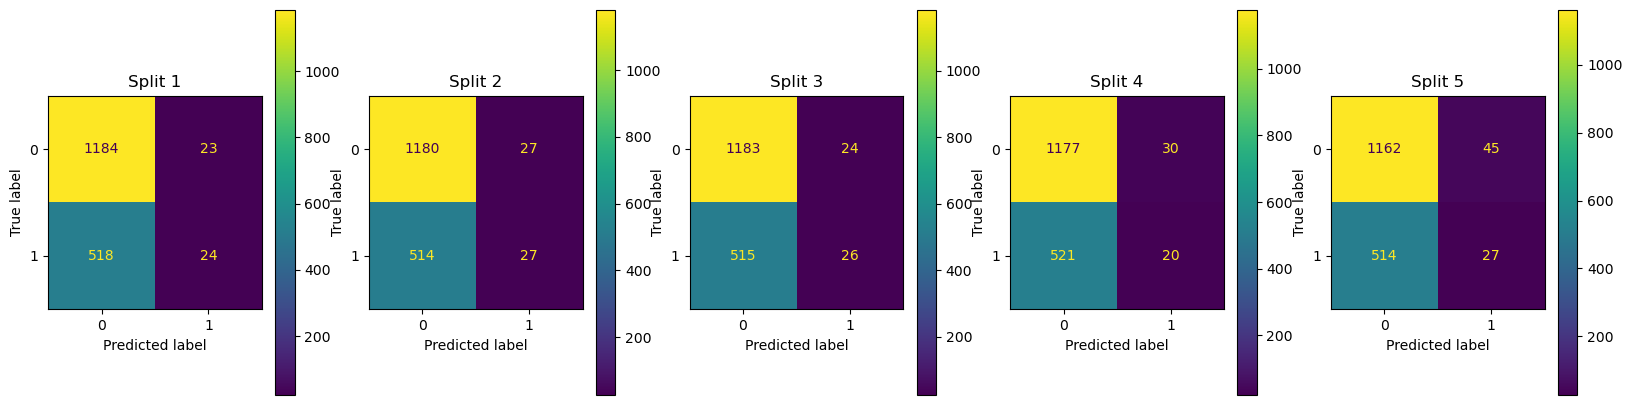

AVERAGE METRICS:
accuracy : 0.6875639953788566
precision (class 0) : 0.6950832366551697
recall (class 0) : 0.9753106876553439
f1-score (class 0) : 0.8116855251716469
roc_auc_score : 0.510567676463013
-----------------------------------


MODEL: logistic_regression (roc_auc_opt)
CONFUSION MATRICES:


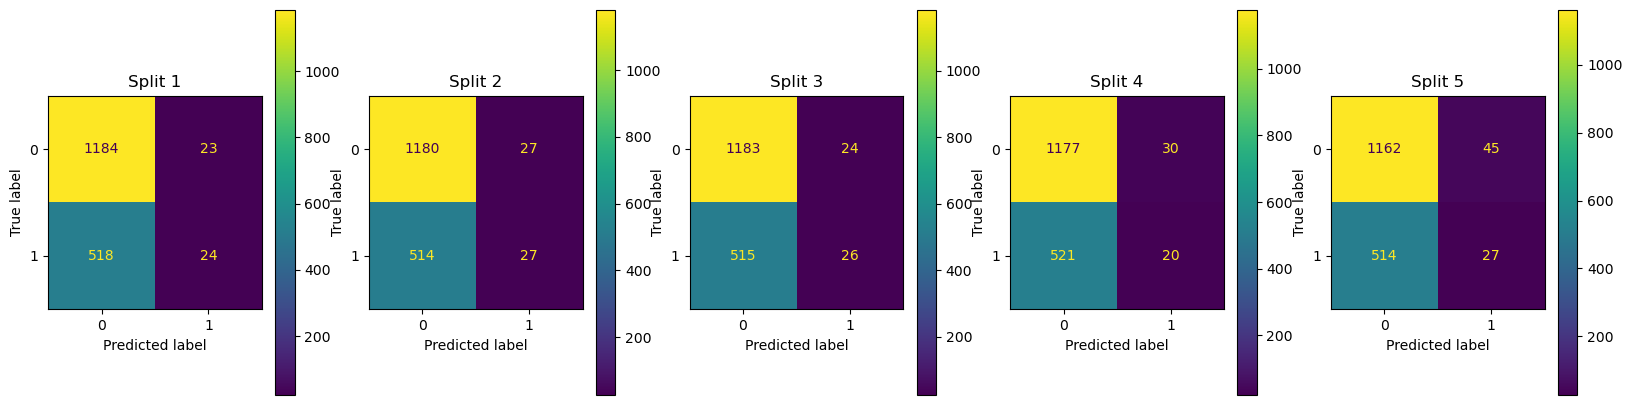

AVERAGE METRICS:
accuracy : 0.6875639953788566
precision (class 0) : 0.6950832366551697
recall (class 0) : 0.9753106876553439
f1-score (class 0) : 0.8116855251716469
roc_auc_score : 0.510567676463013
-----------------------------------


MODEL: random_forest (neg_recall_opt)
CONFUSION MATRICES:


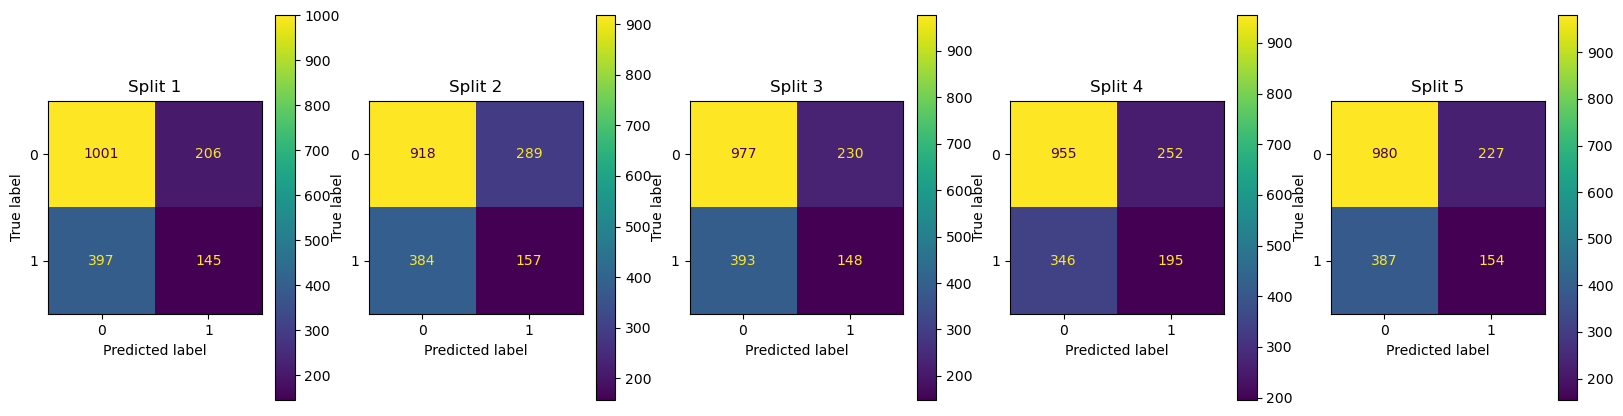

AVERAGE METRICS:
accuracy : 0.6440897904392572
precision (class 0) : 0.7170359496178109
recall (class 0) : 0.8004971002485501
f1-score (class 0) : 0.7563114997984116
roc_auc_score : 0.5478885634929854
-----------------------------------




In [135]:
for (key, model) in models_ambulance_r.items():
    print('MODEL:', key)
    print('CONFUSION MATRICES:')
    metrics = model_metrics(model, X_train, y_train, kfold, 0)
    print('AVERAGE METRICS:')
    for (metric, value) in metrics.items():
        print(metric, ':', value)
    print('-----------------------------------')
    print('\n')

### Check Overfitting

Below, we check for overfitting of our models by comparing the graphs of the training score against the validation score. If the two curves appear to converge as the training samples become bigger, then this is a sign that the model is not overfit.

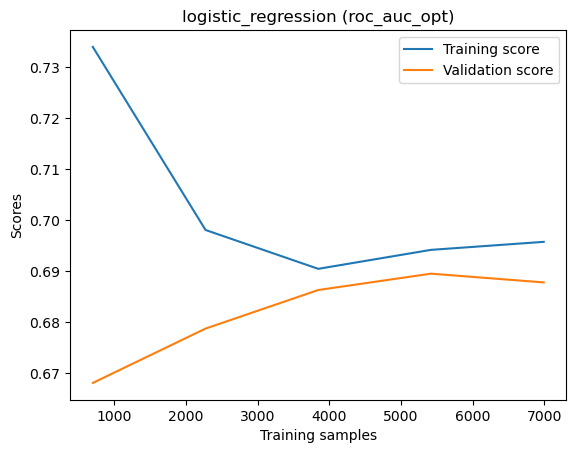

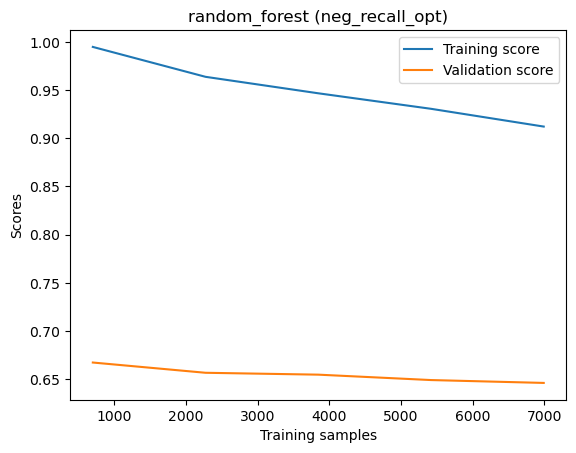

In [136]:
for (key, model) in models_ambulance_r.items():
    if key == 'base_model (log_reg_unweighted)':
        continue
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=kfold)
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation score')
    plt.legend()
    plt.xlabel('Training samples')
    plt.ylabel('Scores')
    plt.title(key)
    plt.show()

### Final Evaluation

As the last step, we test our winning models over the cross validation sets on the test sets, the unseen data. This will give the true performance of our models.

MODEL: logistic_regression (roc_auc_opt)
CONFUSION MATRIX:


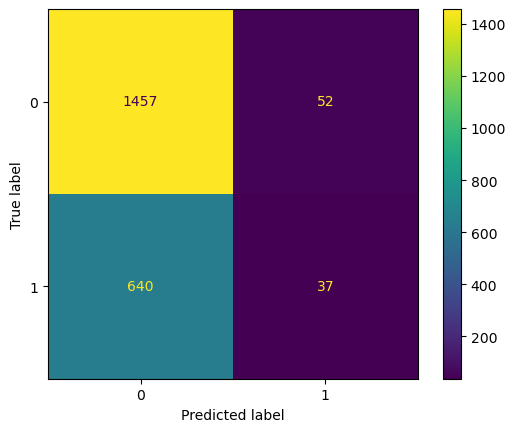

METRICS:
accuracy : 0.6834400731930467
precision (class 0) : 0.6948020982355746
recall (class 0) : 0.9655400927766733
f1-score (class 0) : 0.8080976150859678
roc_auc_score : 0.5100964865655893
-----------------------------------


MODEL: random_forest (neg_recall_opt)
CONFUSION MATRIX:


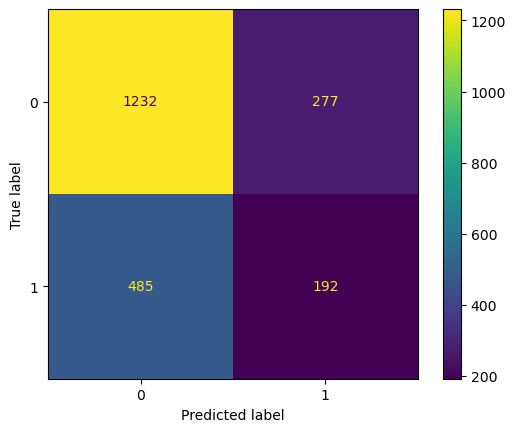

METRICS:
accuracy : 0.6514181152790485
precision (class 0) : 0.7175305765870704
recall (class 0) : 0.8164347249834327
f1-score (class 0) : 0.7637941723496591
roc_auc_score : 0.5500194304385406
-----------------------------------




In [137]:
X_test = Bike_test[features]
y_test = Bike_test['AmbulanceR']

for (key, model) in models_ambulance_r.items():
    if key == 'base_model (log_reg_unweighted)':
        continue
    # evaluate model
    y_pred = model.predict(X_test)

    print('MODEL:', key)
    print('CONFUSION MATRIX:')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('METRICS:')
    print('accuracy', ':', (accuracy_score(y_test, y_pred)))
    print('precision (class 0)', ':', (precision_score(y_test, y_pred, pos_label=0)))
    print('recall (class 0)', ':', (recall_score(y_test, y_pred, pos_label=0)))
    print('f1-score (class 0)', ':', (f1_score(y_test, y_pred, pos_label=0)))
    print('roc_auc_score', ':', (roc_auc_score(y_test, y_pred)))
    print('-----------------------------------')
    print('\n')

## Target: Bike Injury (Binary)

### Cross Validation

We'll first test our models using the BikeInjury column as our target. This has the following values:
- 'O: No Injury'
- 'C: Possible Injury'
- 'B: Suspected Minor Injury'
- 'A: Suspected Serious Injury'
- 'K: Killed':

To avoid complicating the model, we'll first test it by converting it into a binary column:
- `A: Suspected Serious Injury` and `K: Killed` is classified as `1`, i.e. Sever Injury.
- Otherwise, it is classified as `0`, i.e. Not Severy Injury.

Notice in the code below, we don't touch the Bike_test.

We only do the cross-validation on the training data set.

### Set-up

In [138]:
# Start out with out base model
models_bike_injury = {
    'base_model (log_reg_unweighted)': LogisticRegression(penalty=None, max_iter=1000)
}

In [139]:
# Splitting the data into training and test sets, stratifying on Ambulance Response
Bike_train, Bike_test = train_test_split(BikeCrashData.copy(),
                                        shuffle=True, 
                                        test_size=0.2, 
                                        random_state=614,
                                        stratify=BikeCrashData['BikeInjury'])

features = Bike_train.drop(columns=['AmbulanceR','BikeInjury']).columns
X_train = Bike_train[features]
y_train = Bike_train['BikeInjury']


In [140]:
# Create a list of class weights to test out in different models
inj_weights_bike_injury = list(range(8, 12))
inj_weights_bike_injury = [{0: weight, 1: 100 - weight} for weight in inj_weights_bike_injury]
inj_weights_bike_injury.append('balanced')
inj_weights_bike_injury.append(None)

In [141]:
# Using GridSearchCV to find the best hyperparameters for the Logistic Regression model
inj_log_grid_cv = GridSearchCV(LogisticRegressionThreshold(), 
                          param_grid = {'threshold': [threshold / 100 for threshold in list(range(45, 55))],
                                        'penalty': [None],
                                        'max_iter': [1000],
                                        'class_weight': inj_weights_bike_injury}, 
                          scoring = 'recall',
                          cv = kfold)

inj_log_grid_cv.fit(X_train, y_train)

# Add our best estimator to the models to cross-validate
models_bike_injury['logistic_regression (recall_opt)'] = inj_log_grid_cv.best_estimator_

In [142]:
# Using GridSearchCV to find the best hyperparameters for the Random Forest model
inj_for_grid_cv = GridSearchCV(RandomForestClassifierThreshold(), 
                          param_grid = {'threshold': [0.4],
                                        'n_estimators': [250, 500, 1000],
                                        'max_depth': [8, 10, 12],
                                        'class_weight': ['balanced']},
                          scoring = 'recall',
                          cv = kfold)

inj_for_grid_cv.fit(X_train, y_train)

# Add our best estimator to the models to cross-validate
models_bike_injury['random_forest (recall_opt)'] = inj_for_grid_cv.best_estimator_

In [143]:
# Print out models
models_bike_injury

{'base_model (log_reg_unweighted)': LogisticRegression(max_iter=1000, penalty=None),
 'logistic_regression (recall_opt)': LogisticRegressionThreshold(class_weight='balanced', max_iter=1000,
                             multi_class='deprecated', penalty=None,
                             threshold=0.45),
 'random_forest (recall_opt)': RandomForestClassifierThreshold(class_weight='balanced', max_depth=8,
                                 n_estimators=250, threshold=0.4)}

## Results

For the `BikeInjury` feature, the minority class `Sever Injury`, is the most important class we want to make predictions for. Therefore, we focus on evaluating the metrics of our models for the minority class.

We again record the average values of the metrics of each model over all the cross-validation folds.

MODEL: base_model (log_reg_unweighted)
CONFUSION MATRICES:


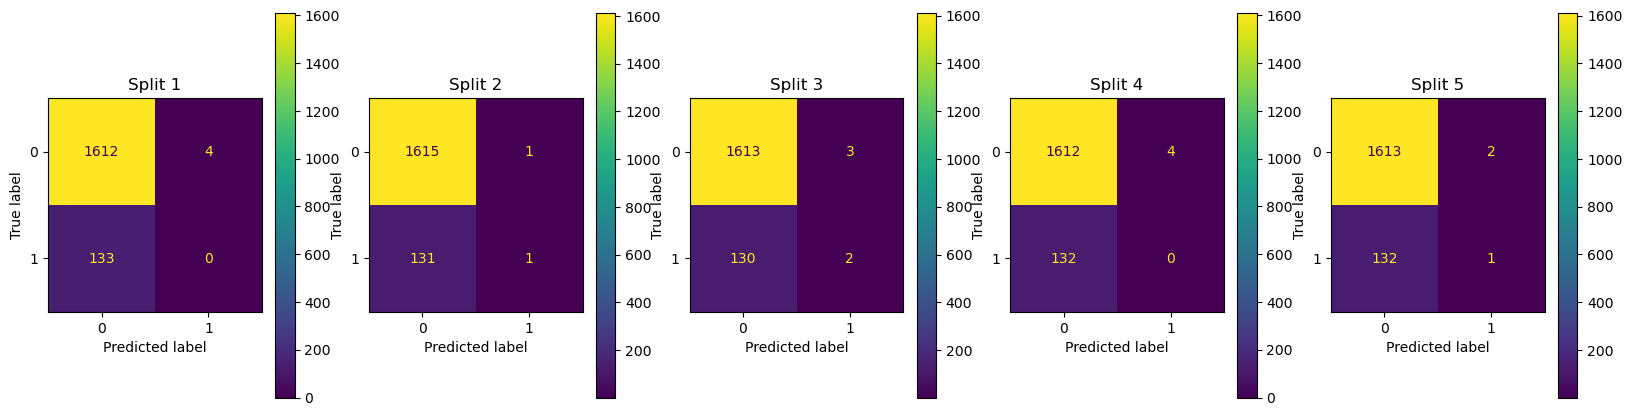

AVERAGE METRICS:
accuracy : 0.9231210904433131
precision (class 1) : 0.24666666666666667
recall (class 1) : 0.006049213943950786
f1-score (class 1) : 0.011765667155848068
roc_auc_score : 0.5021581937052618
-----------------------------------


MODEL: logistic_regression (recall_opt)
CONFUSION MATRICES:


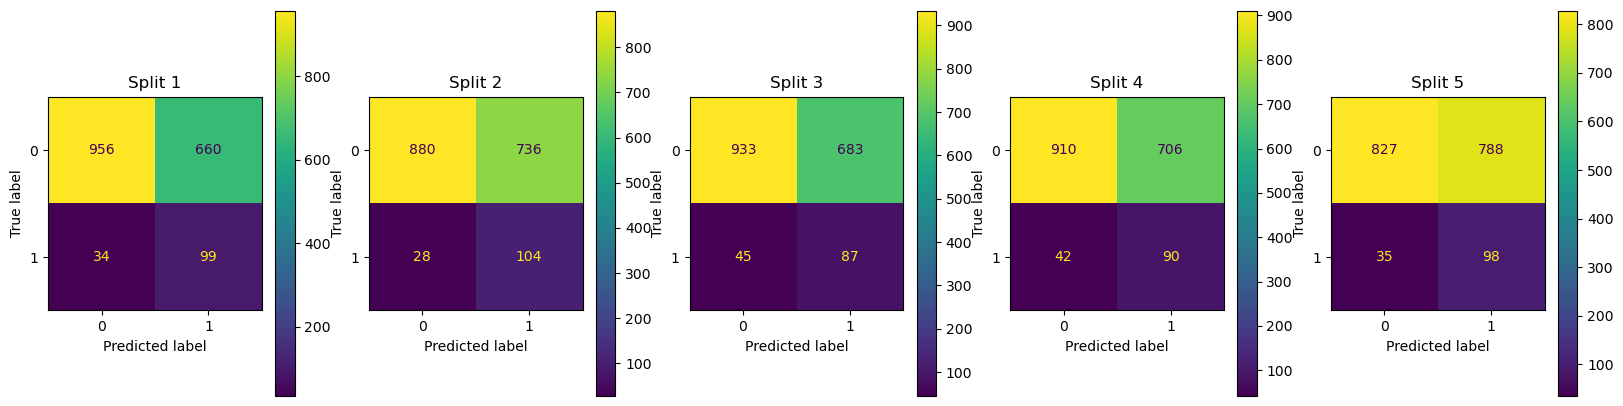

AVERAGE METRICS:
accuracy : 0.5701827000194946
precision (class 1) : 0.11818122537020788
recall (class 1) : 0.7219981772613352
f1-score (class 1) : 0.20303609479620963
roc_auc_score : 0.6398674100603337
-----------------------------------


MODEL: random_forest (recall_opt)
CONFUSION MATRICES:


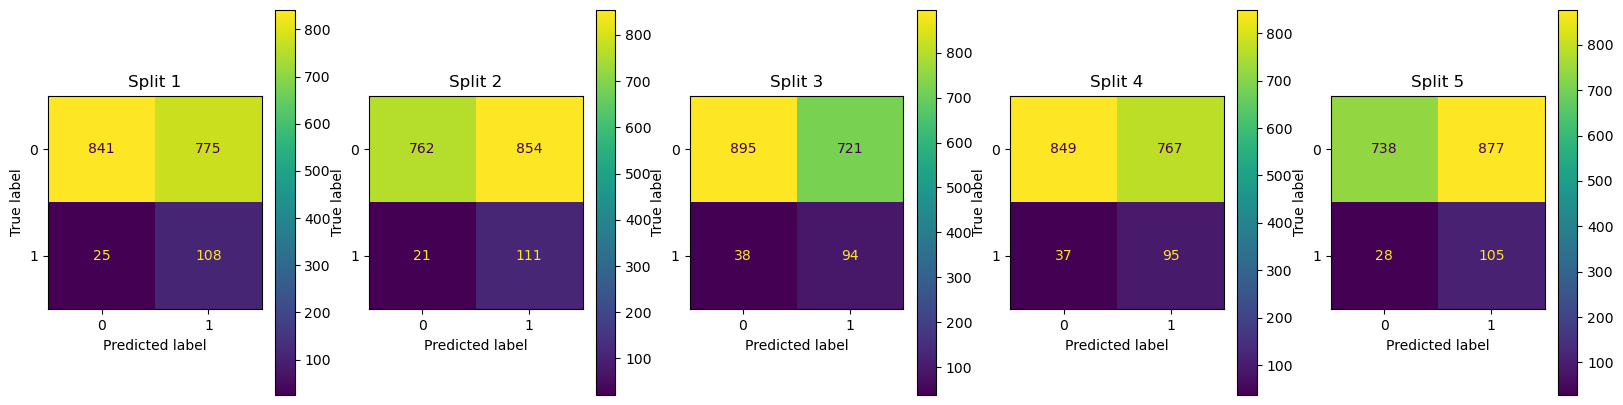

AVERAGE METRICS:
accuracy : 0.5260248746259713
precision (class 1) : 0.11396141922285138
recall (class 1) : 0.7748462064251539
f1-score (class 1) : 0.19859557224804478
roc_auc_score : 0.6402360342734849
-----------------------------------




In [144]:
for (key, model) in models_bike_injury.items():
    print('MODEL:', key)
    print('CONFUSION MATRICES:')
    metrics = model_metrics(model, X_train, y_train, kfold)
    print('AVERAGE METRICS:')
    for (metric, value) in metrics.items():
        print(metric, ':', value)
    print('-----------------------------------')
    print('\n')

### Check Overfitting

We again check our models for overfitting through visualization.

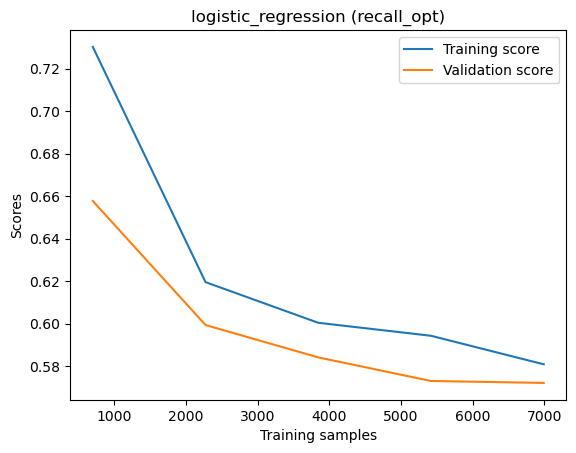

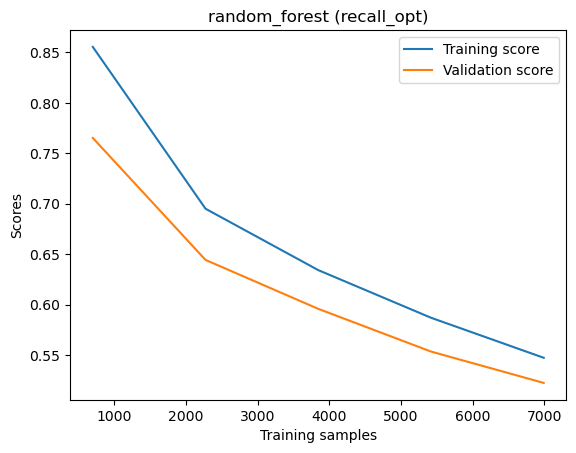

In [145]:
for (key, model) in models_bike_injury.items():
    if key == 'base_model (log_reg_unweighted)':
        continue
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5)
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation score')
    plt.legend()
    plt.xlabel('Training samples')
    plt.ylabel('Scores')
    plt.title(key)
    plt.show()

### Final Evaluation

We test our winning models from above on the training sets, the unseen data.

MODEL: logistic_regression (recall_opt)
CONFUSION MATRIX:


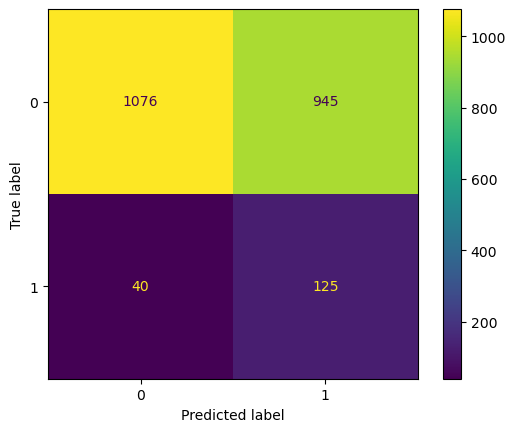

METRICS:
accuracy : 0.5494053064958829
precision (class 1) : 0.11682242990654206
recall (class 1) : 0.7575757575757576
f1-score (class 1) : 0.20242914979757085
roc_auc_score : 0.6449927278724904
-----------------------------------


MODEL: random_forest (recall_opt)
CONFUSION MATRIX:


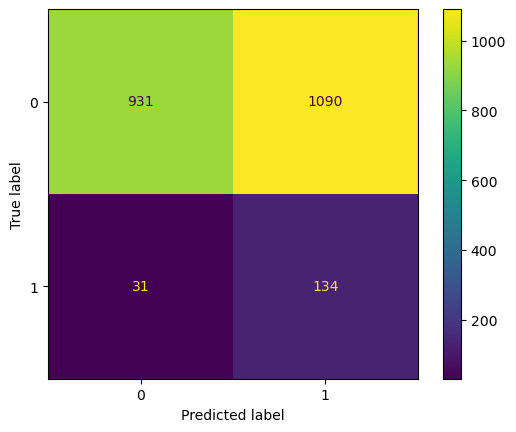

METRICS:
accuracy : 0.48719121683440075
precision (class 1) : 0.10947712418300654
recall (class 1) : 0.8121212121212121
f1-score (class 1) : 0.1929445644348452
roc_auc_score : 0.6363921251105813
-----------------------------------




In [146]:
X_test = Bike_test[features]
y_test = Bike_test['BikeInjury']

for (key, model) in models_bike_injury.items():
    if key == 'base_model (log_reg_unweighted)':
        continue
    # evaluate model
    y_pred = model.predict(X_test)

    print('MODEL:', key)
    print('CONFUSION MATRIX:')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    print('METRICS:')
    print('accuracy', ':', (accuracy_score(y_test, y_pred)))
    print('precision (class 1)', ':', (precision_score(y_test, y_pred)))
    print('recall (class 1)', ':', (recall_score(y_test, y_pred)))
    print('f1-score (class 1)', ':', (f1_score(y_test, y_pred)))
    print('roc_auc_score', ':', (roc_auc_score(y_test, y_pred)))
    print('-----------------------------------')
    print('\n')